In [1]:
import pandas as pd

# Load the Excel file to check available sheets and structure
file_path = "Transformed_Data.xlsx"
excel_data = pd.ExcelFile(file_path)

# Get the names of all the sheets in the Excel file
excel_data.sheet_names


['Customers', 'Inventory', 'Products', 'Promotions', 'Sales']

In [2]:
# Load data from all sheets
data_dict = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Show preview of the first few rows of each sheet
data_preview = {sheet: data.head() for sheet, data in data_dict.items()}
data_preview

{'Customers':    Customer_ID   Name              Email    Location  Join_Date  \
 0            1  User1  user1@example.com       Miami 2023-12-25   
 1            2  User2  user2@example.com       Texas 2023-12-04   
 2            3  User3  user3@example.com  California 2023-09-18   
 3            4  User4  user4@example.com     Florida 2023-03-25   
 4            5  User5  user5@example.com       Texas 2023-12-13   
 
    Join_Date_Day  Join_Date_Month  Join_Date_Year Join_Date_Formatted  
 0             25               12            2023    25 December 2023  
 1              4               12            2023    04 December 2023  
 2             18                9            2023   18 September 2023  
 3             25                3            2023       25 March 2023  
 4             13               12            2023    13 December 2023  ,
 'Inventory':    Inventory_ID  Product_ID Warehouse_Location  Stock_Quantity Last_Updated  \
 0             1           8           New Yo

Calculating Customer Lifetime Value (CLV)

In [3]:
# Load necessary data
sales_data = data_dict['Sales']
customers_data = data_dict['Customers']

# Convert Transaction_Date to datetime for analysis
sales_data['Transaction_Date'] = pd.to_datetime(sales_data['Transaction_Date'])

# Calculate total revenue and number of purchases per customer
customer_revenue = sales_data.groupby('Customer_ID')['Amount'].sum().reset_index(name='Total_Revenue')
customer_purchases = sales_data.groupby('Customer_ID')['Transaction_ID'].count().reset_index(name='Purchase_Count')

# Merge data to calculate average purchase value and frequency
customer_data = pd.merge(customer_revenue, customer_purchases, on='Customer_ID')
customer_data['Average_Purchase_Value'] = customer_data['Total_Revenue'] / customer_data['Purchase_Count']

# Calculate purchase frequency per customer
total_customers = customers_data['Customer_ID'].nunique()
customer_data['Purchase_Frequency'] = customer_data['Purchase_Count'] / total_customers

# Assume average customer lifespan in years (estimated as 1 year for simplicity)
customer_data['Customer_Lifespan'] = 1

# Calculate CLV
customer_data['CLV'] = customer_data['Average_Purchase_Value'] * customer_data['Purchase_Frequency'] * customer_data['Customer_Lifespan']
customer_data = customer_data[['Customer_ID', 'CLV']].sort_values(by='CLV', ascending=False)

# Display top 5 high-value customers
customer_data.head()

,Customer_ID,CLV
19,20,48.962133
6,7,39.494400
3,4,32.409867
7,8,28.567800
26,28,27.963133


Sales Trends Analysis

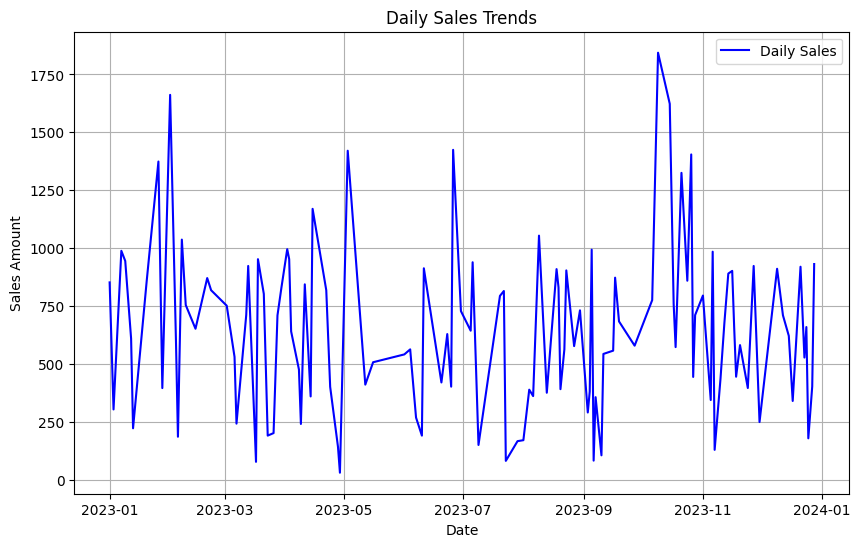

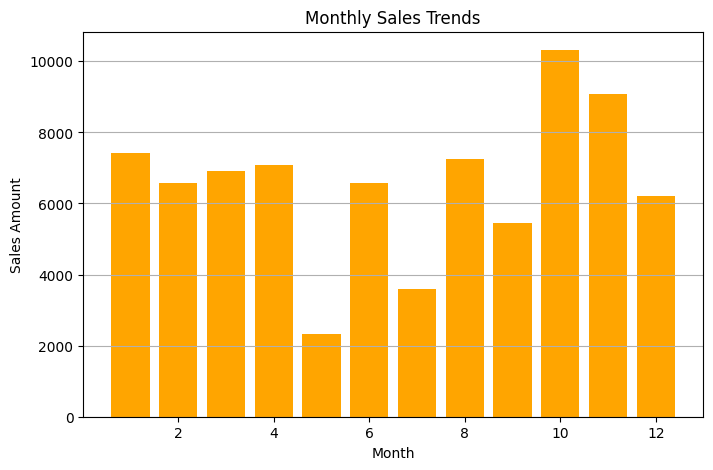

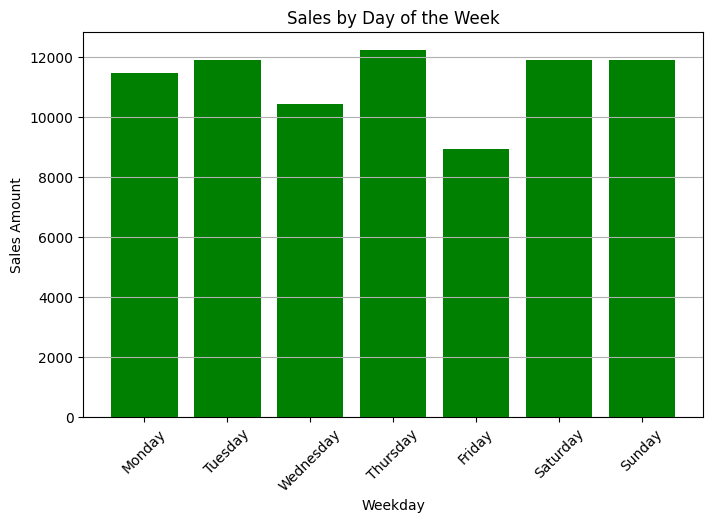

{'Daily_Sales_Preview':   Transaction_Date  Amount
 0       2023-01-01  851.99
 1       2023-01-03  303.35
 2       2023-01-07  988.40
 3       2023-01-09  944.43
 4       2023-01-12  609.71,
 'Monthly_Sales_Preview':    Transaction_Month   Amount
 0                  1  7428.35
 1                  2  6573.62
 2                  3  6919.42
 3                  4  7068.97
 4                  5  2338.23,
 'Weekday_Sales_Preview':   Transaction_Weekday    Amount
 0              Monday  11481.36
 1             Tuesday  11914.30
 2           Wednesday  10419.84
 3            Thursday  12224.05
 4              Friday   8937.31}

In [4]:
import matplotlib.pyplot as plt

# Aggregate sales by date to analyze daily trends
daily_sales = sales_data.groupby('Transaction_Date')['Amount'].sum().reset_index()

# Add columns for Month and Weekday
sales_data['Transaction_Month'] = sales_data['Transaction_Date'].dt.month
sales_data['Transaction_Weekday'] = sales_data['Transaction_Date'].dt.day_name()

# Analyze monthly/seasonal trends
monthly_sales = sales_data.groupby('Transaction_Month')['Amount'].sum().reset_index()

# Analyze weekday patterns
weekday_sales = sales_data.groupby('Transaction_Weekday')['Amount'].sum().reset_index()
weekday_sales = weekday_sales.set_index('Transaction_Weekday').reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

# Plotting daily sales trends
plt.figure(figsize=(10, 6))
plt.plot(daily_sales['Transaction_Date'], daily_sales['Amount'], color='blue', label='Daily Sales')
plt.title('Daily Sales Trends')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid()
plt.show()

# Plotting monthly/seasonal trends
plt.figure(figsize=(8, 5))
plt.bar(monthly_sales['Transaction_Month'], monthly_sales['Amount'], color='orange')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.grid(axis='y')
plt.show()

# Plotting weekly/weekday patterns
plt.figure(figsize=(8, 5))
plt.bar(weekday_sales['Transaction_Weekday'], weekday_sales['Amount'], color='green')
plt.title('Sales by Day of the Week')
plt.xlabel('Weekday')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Return summarized trend data
{
    "Daily_Sales_Preview": daily_sales.head(),
    "Monthly_Sales_Preview": monthly_sales.head(),
    "Weekday_Sales_Preview": weekday_sales.head()
}


Inventory Turnover Rate Analysis

In [5]:
# Load necessary data
inventory_data = data_dict['Inventory']
products_data = data_dict['Products']

# Calculate Cost of Goods Sold (COGS) from total sales amount
cogs = sales_data['Amount'].sum()

# Merge Inventory and Products data to calculate stock value
inventory_products = pd.merge(inventory_data, products_data, on='Product_ID')
inventory_products['Stock_Value'] = inventory_products['Stock_Quantity'] * inventory_products['Price']

# Calculate average inventory value
average_inventory_value = inventory_products['Stock_Value'].mean()

# Calculate Inventory Turnover Rate
inventory_turnover_rate = cogs / average_inventory_value

# Summarize stock levels and turnover rate
inventory_summary = inventory_products.groupby('Product_Name')['Stock_Quantity'].sum().reset_index()
inventory_summary['Stock_Value'] = inventory_products.groupby('Product_Name')['Stock_Value'].sum().values
inventory_summary = inventory_summary.sort_values(by='Stock_Value', ascending=False)

inventory_turnover_rate, inventory_summary.head()


(np.float64(0.893729085392602),
   Product_Name  Stock_Quantity  Stock_Value
 2   Smartphone            6415   4498514.64
 0   Headphones            9310   3986324.89
 3   Smartwatch            6594   2464067.96
 1       Laptop            7343   1913463.40
 4       Tablet            1231    361643.18)

 Market Basket Analysis

In [13]:
%pip install pandas mlxtend openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Load the Excel file and extract the Sales and Products tables
excel_file = 'Transformed_Data.xlsx'
sales_df = pd.read_excel(excel_file, sheet_name='Sales')
products_df = pd.read_excel(excel_file, sheet_name='Products')

# Step 2: Prepare data for Market Basket Analysis
# Group transactions by Customer_ID and create a list of products purchased by each customer
basket = sales_df.groupby(['Customer_ID', 'Product_ID'])['Amount'].sum().unstack().reset_index().fillna(0).set_index('Customer_ID')

# Convert the data to binary format (1 if the product was purchased, 0 otherwise)
def encode_units(x):
    return 1 if x > 0 else 0

basket_sets = basket.applymap(encode_units)

# Step 3: Perform Market Basket Analysis using the Apriori algorithm
# Find frequent itemsets with a minimum support of 0.05 (5%)
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)

# Generate association rules with a minimum confidence of 0.5 (50%)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Filter rules to only include rules with a lift greater than 1 (positive correlation)
rules = rules[rules['lift'] > 1]

# Step 4: Map Product IDs to Product Names
# Create a dictionary to map Product_ID to Product_Name
product_name_map = dict(zip(products_df['Product_ID'], products_df['Product_Name']))

# Function to replace Product IDs with Product Names in the rules
def map_product_names(items):
    item_list = sorted([product_name_map[item] for item in items])
    return ", ".join(item_list)

# Apply the mapping to antecedents and consequents
rules['antecedents'] = rules['antecedents'].apply(lambda x: map_product_names(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: map_product_names(list(x)))

# Step 5: Beautify the output
# Select only relevant columns and sort by confidence
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
rules = rules.sort_values(by=['confidence'], ascending=False)

# Disable row truncation to print all rows without skipping
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Step 6: Print all product recommendations without skipping rows
print("All Product Recommendations:")
print("=" * 50)
for index, row in rules.iterrows():
    print(f"If a customer buys **{row['antecedents']}**, they are likely to buy **{row['consequents']}**.")
    print(f"- Support: {row['support']:.4f}")
    print(f"- Confidence: {row['confidence']:.4f}")
    print(f"- Lift: {row['lift']:.4f}")
    print("-" * 50)


All Product Recommendations:
If a customer buys **Headphones, Laptop**, they are likely to buy **Laptop, Smartphone, Smartwatch, Smartwatch**.
- Support: 0.0690
- Confidence: 1.0000
- Lift: 14.5000
--------------------------------------------------
If a customer buys **Laptop, Smartwatch**, they are likely to buy **Headphones, Laptop, Smartphone, Smartwatch**.
- Support: 0.0690
- Confidence: 1.0000
- Lift: 14.5000
--------------------------------------------------
If a customer buys **Headphones, Smartwatch**, they are likely to buy **Laptop, Laptop, Smartphone, Smartwatch**.
- Support: 0.0690
- Confidence: 1.0000
- Lift: 14.5000
--------------------------------------------------
If a customer buys **Laptop, Laptop, Smartwatch**, they are likely to buy **Headphones, Smartphone, Smartwatch**.
- Support: 0.0690
- Confidence: 1.0000
- Lift: 14.5000
--------------------------------------------------
If a customer buys **Headphones, Laptop, Smartwatch**, they are likely to buy **Laptop, Sma

C:\Users\SANYA\AppData\Local\Temp\ipykernel_21868\3103454102.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)
c:\Users\SANYA\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
